**Explore the Example Data**
Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in /tmp.

NOTE: The 2,000 images used in this exercise are excerpted from the "Dogs vs. Cats" dataset available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2024-03-19 17:04:02--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.207, 108.177.13.207, 74.125.26.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   178MB/s    in 0.4s    

2024-03-19 17:04:02 (178 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/MyDrive/Colab Notebooks/CV_LAB')
zip_ref.close()

In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/CV_LAB/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.207.jpg', 'cat.426.jpg', 'cat.858.jpg', 'cat.48.jpg', 'cat.127.jpg', 'cat.967.jpg', 'cat.292.jpg', 'cat.227.jpg', 'cat.52.jpg', 'cat.237.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import pylab as pl
from sklearn.metrics import confusion_matrix,accuracy_score

['dogs', 'cats']


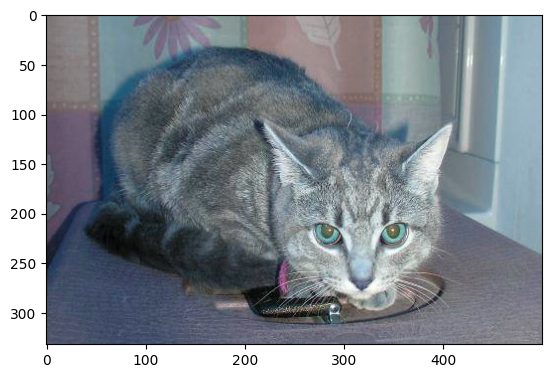

In [ ]:
class_names=os.listdir(train_dir)

print(class_names)

image_paths=[]
image_classes=[]

def img_list(path):
 return (os.path.join(path,f) for f in os.listdir(path))

for training_name in class_names:
  dir_=os.path.join(train_dir,training_name)
  class_path=img_list(dir_)
  image_paths+=class_path

len(image_paths)

image_classes_0=[0]*(len(image_paths)//2)
image_classes_1=[1]*(len(image_paths)//2)
image_classes=image_classes_0+image_classes_1

des_list=[]
orb=cv2.ORB_create()
im=cv2.imread(train_cat_fnames[1])
def draw_keypoints(vis, keypoints, color = (0, 255, 255)):
  for kp in keypoints:
   x, y = kp.pt
   plt.imshow(cv2.circle(vis, (int(x), int(y)), 2,
  color))


D=[]
for i in range(len(image_paths)):
 D.append((image_paths[i],image_classes[i]))
dataset = D
random.shuffle(dataset)
train = dataset[:180]
test = dataset[180:]
image_paths, y_train = zip(*train)
image_paths_test, y_test = zip(*test)

des_list=[]
orb=cv2.ORB_create()
im=cv2.imread(image_paths[1])
plt.imshow(im)




ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 32 and the array at index 1 has size 1

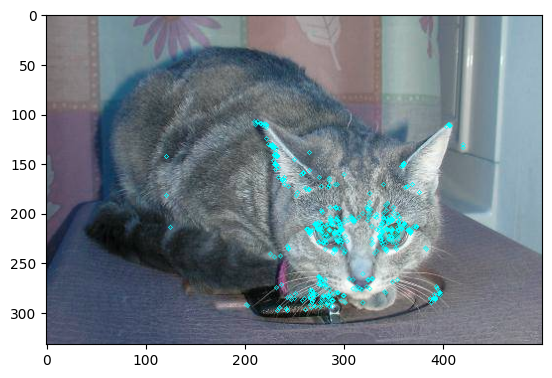

In [ ]:
def draw_keypoints(vis, keypoints, color = (0, 255, 255)):
  for kp in keypoints:
    x, y = kp.pt
    plt.imshow(cv2.circle(vis, (int(x), int(y)), 2,
    color))

kp = orb.detect(im,None)
kp, des = orb.compute(im, kp)
img=draw_keypoints(im,kp)

for image_pat in image_paths:
  im=cv2.imread(image_pat)
  kp=orb.detect(im,None)
  keypoints,descriptor= orb.compute(im, kp)
  des_list.append((image_pat,descriptor))

descriptors=des_list[0][1]
for image_path,descriptor in des_list[1:]:
 descriptors=np.vstack((descriptors,descriptor))

descriptors.shape

descriptors_float=descriptors.astype(float)

from scipy.cluster.vq import kmeans,vq
k=200
voc,variance=kmeans(descriptors_float,k,1)
im_features=np.zeros((len(image_paths),k),"float32")
for i in range(len(image_paths)):
  words,distance=vq(des_list[i][1],voc)
  for w in words:
    im_features[i][w]+=1

from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler().fit(im_features)
im_features=stdslr.transform(im_features)

from sklearn.svm import LinearSVC
clf=LinearSVC(max_iter=80000)

clf.fit(im_features,np.array(y_train))

des_list_test=[]
for image_pat in image_paths_test:
  image=cv2.imread(image_pat)
  kp=orb.detect(image,None)
  keypoints_test,descriptor_test= orb.compute(image, kp)
  des_list_test.append((image_pat,descriptor_test))
len(image_paths_test)

print(des_list_test)

from scipy.cluster.vq import vq
test_features=np.zeros((len(validation_dir),k),"float32")
for i in range(len(validation_dir)):
  words,distance=vq(des_list_test[i][1],voc)
  for w in words:
    test_features[i][w]+=1

test_features

test_features=stdslr.transform(test_features)

predict_classes=[]

for i in clf.predict(test_features):
  if i==1:
   predict_classes.append("Cat")
  else:
   predict_classes.append("Dog")

print(true_classes)
print(predict_classes)

clf.predict(test_features)

accuracy=accuracy_score(true_classes,predict_classes)
print(accuracy)

for image_pat in train_cat_fnames:
  im=cv2.imread(image_pat)
  kp=orb.detect(im,None)
  keypoints,descriptor= orb.compute(im, kp)
  des_list.append([image_pat,descriptor])

for image_pat in train_dog_fnames:
  im=cv2.imread(image_pat)
  kp=orb.detect(im,None)
  keypoints,descriptor= orb.compute(im, kp)
  des_list.append([image_pat,descriptor])

im=cv2.imread(des_list[0])

from google.colab.patches import cv2_imshow

cv2_imshow(im)

des_list

descriptors=des_list[0][1]
for image_path,descriptor in des_list[1:]:
 descriptors=np.vstack((descriptors,descriptor))

descriptors

descriptors_float=descriptors.astype(float)
from scipy.cluster.vq import kmeans,vq
k=200
voc,variance=kmeans(descriptors_float,k,1)
im_features=np.zeros((len(image_paths),k),"float32")
for i in range(len(image_paths)):
 words,distance=vq(des_list[i][1],voc)
 for w in words:
  im_features[i][w]+=1
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler().fit(im_features)
im_features=stdslr.transform(im_features)
from sklearn.svm import LinearSVC
clf=LinearSVC(max_iter=80000)
clf.fit(im_features,np.array(y_train))




In [ ]:
# Predict classes for test images
predictions = clf.predict(test_features)

# Define true classes based on y_test
true_classes = ["Cat" if label == 0 else "Dog" for label in y_test]


In [ ]:
# Predict classes for test images
predictions = clf.predict(test_features)

# Print true and predicted classes
print("True classes:", y_test)
print("Predicted classes:", predict_classes)


True classes: (0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1